# Applied Data Science Capstone

###  - Building a recommendation engine for new business locations -

## Important Info:

It seems GitHub integration of IBM Watson Studio prevents maps and images from being available when looking at the Jupyter notebook on GitHub. Therefore I recommend you to follow this link to the IBM Watson Studio where it should be displayed fine: [https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d6bb278b-5b58-4154-af22-8da73c1e8d39/view?access_token=d1b2450970a85ad6121e6b19687ea07150ae9df22afe057f12eaa8dc386980d4](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d6bb278b-5b58-4154-af22-8da73c1e8d39/view?access_token=d1b2450970a85ad6121e6b19687ea07150ae9df22afe057f12eaa8dc386980d4) 

## Introduction

Starting a new business involves big risks for a company or an entrepreneur. Great manual efforts are necessary to assemble enough information to form a solid decision about potential neighborhoods for the new business location. The complexity of gathering such information often leads to the rough pre-selection of neighborhoods, in order to reduce the workload. This results in potentially promising neighborhoods not being exploited. Such a workload reducing approach even prevents neighborhood (and city) development, once these neighborhoods are generally known as not interesting or too risky for new businesses.

Today's knowledge in data science and the plethora of existing platforms, tools, libraries and APIs empower the construction of a recommendation system for the described problem. By building a recommendation engine, we are able to find the best possible spot for new businesses, even in neighborhoods that would otherwise be disregarded. Using fine grained open data information sources allows us not only to provide recommendations on a coarse neighborhood basis, but even down to the tax lot level. The attracting or repelling influence of points of interest (PoI) can be taken into account when new recommendations are made. The preferences (or objection) towards PoI categories would be used to calculate a vector pulling the recommendation center away from the neighborhood centroid, towards a more preferable location.

Such a recommendation system not only redundantizes the tedious work of manually creating a profile for preferred locations, but picks the best locations from all over the city in only a few seconds, taking large amounts of information into account. Finally, we can even cope for the risk affinity of the enterpreneur by letting him choose all flavours between low risk with high competition, and high risk with low competition at the new business location.

As a proof of concept implementation, we limit the scope of the recommendation engine to the city of New York. This PoC intends to answer the question of whether we can build a recommendation system for new business locations, using the new business' profile, along with additional preferences such as the rental costs, the stakeholders' risk affinity and importance of proximity to a police station. The resulting recommendation engine can be boosted by adding new categories made of points of interest. 

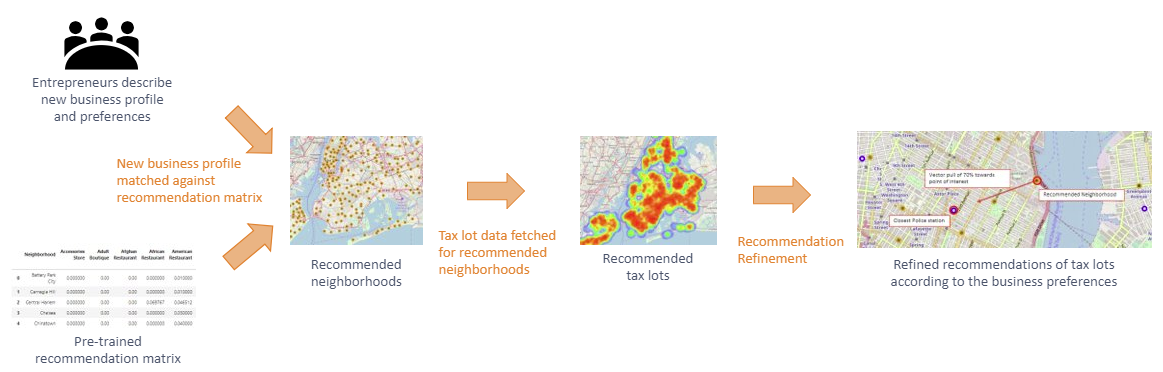

## Data

We need to combine different data sources which have to be tapped first:

- [Neighborhood profile matrix from project "Segmenting and Clustering Neighborhoods in New York City"](https://www.coursera.org/learn/applied-data-science-capstone/ungradedLti/f0QY7/segmenting-and-clustering-neighborhoods-in-new-york-city)
- [PLUTO: Extensive land use and geographic data at the tax lot level](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)
- [Police stations](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)


#### Future: Recommendation Enhancement through new PoI categories

Additional data could be incorporated by scraping the resources listed below:

- [Fire stations](https://data.cityofnewyork.us/widgets/hc8x-tcnd)
- [Hospitals](https://profiles.health.ny.gov/hospital/county_or_region//service:Emergency+Department)
- [Schools](https://data.cityofnewyork.us/Education/2017-2018-School-Locations/p6h4-mpyy)
- [Crime rate](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)

#### Import the required packages for data preparation

In [1]:
!conda install -c conda-forge folium=0.5.0 geopy --yes

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
geopy                     1.18.1                     py_0    conda-forge


In [2]:
import math
import numpy as np
import pandas as pd
import json
from collections import namedtuple
from zipfile import ZipFile
import folium
from folium import plugins
from folium.plugins import HeatMap
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

### 1. Neighborhood profile matrix

In [3]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
    len(neighborhoods['Borough'].unique()),
    neighborhoods.shape[0]
))
neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent='my-data-science-project')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        parse_html=False).add_to(map_newyork)
    
map_newyork

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Define secret Foursquare parameters

In [5]:
# The code was removed by Watson Studio for sharing.

#### Define not so secret Foursquare parameters

In [6]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100

Reuse the code to get nerby venues from the previous projects:

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        try:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
            
            response = requests.get(url)
            results = response.json()["response"]['groups'][0]['items']
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except KeyError as e:
            print('Failed to fetch', name, ':', response.text)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 431 uniques categories.


One hot encode the venue categories to build the profile matrix:

In [9]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Warehouse Store,Waste Facility,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Show the head of the grouped neighborhood profiles used in the future for the recommendations:

In [10]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,...,Warehouse Store,Waste Facility,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. PLUTO dataset
The pluto data set contains a lot of information on the tax lot level. We use this dataset to estimate the cost to either buy or rent a new business location at that tax lot.

First, let's fetch the huge dataset:

In [11]:
!wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1_1_csv.zip

--2018-12-27 23:31:31--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1_1_csv.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 23.207.4.181, 2600:1404:e000:2a0::1500, 2600:1404:e000:2b6::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|23.207.4.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76185085 (73M) [application/zip]
Saving to: ‘nyc_pluto_18v1_1_csv.zip.2’

100%[======================================>] 76,185,085  60.1MB/s   in 1.2s   

2018-12-27 23:31:34 (60.1 MB/s) - ‘nyc_pluto_18v1_1_csv.zip.2’ saved [76185085/76185085]



In [12]:
with ZipFile('nyc_pluto_18v1_1_csv.zip', 'r') as zf:
    zf.extract('dcp_pluto_18v11.csv', '.')

We are basically only interested in the tax lot location, the size and the value, form which we calculate the value per foot of the tax lot:

In [13]:
pluto_columns = ['xcoord', 'ycoord', 'lotarea', 'assesstot']
df_pluto = pd.read_csv('dcp_pluto_18v11.csv', usecols=pluto_columns).dropna()

# Only use the rows which will result in a finite value per foot
df_pluto = df_pluto[df_pluto['lotarea'] > 0]
df_pluto['value_per_foot'] = df_pluto['assesstot'] / df_pluto ['lotarea']

df_pluto.head()

,lotarea,assesstot,xcoord,ycoord,value_per_foot
1,32218,72573951,980160.0,200125.0,2252.590198
2,11255,2641050,980389.0,197506.0,234.655709
3,4613,684900,980357.0,197392.0,148.471710
4,1410,820800,982388.0,198261.0,582.127660
5,1455,531450,983352.0,196911.0,365.257732


In [14]:
df_pluto.shape

(833695, 5)

#### Convert NY Long Island cooridnate system coordinates into latitude / longitude
The coordinates are expressed in a [different coordinate system](http://spatialreference.org/ref/epsg/3628/). Hence we need to convert xcoord and ycoord to latitude and longitude:

In [15]:
# http://spatialreference.org/ref/epsg/3628/
# WGS84 Bounds: -74.2700, 40.4700, -71.7500, 41.3100
# Projected Bounds: 909126.0155, 110626.2880, 1610215.3590, 424498.0529

x_long_min = 909126.0155
x_long_max = 1610215.3590
x_min = -74.2700
x_max = -71.7500

def x_scale(val):
    return (((val - x_long_min) * (x_max - x_min)) / (x_long_max - x_long_min)) + x_min

y_long_min = 110626.2880
y_long_max = 424498.0529
y_min = 40.4700
y_max = 41.3100

def y_scale(val):
    return (((val - y_long_min) * (y_max - y_min)) / (y_long_max - y_long_min)) + y_min

df_pluto['Longitude'] = df_pluto['xcoord'].apply(x_scale).astype(float)
df_pluto['Latitude'] = df_pluto['ycoord'].apply(y_scale).astype(float)
df_pluto.head()

,lotarea,assesstot,xcoord,ycoord,value_per_foot,Longitude,Latitude
1,32218,72573951,980160.0,200125.0,2252.590198,-74.014675,40.709521
2,11255,2641050,980389.0,197506.0,234.655709,-74.013852,40.702512
3,4613,684900,980357.0,197392.0,148.471710,-74.013967,40.702207
4,1410,820800,982388.0,198261.0,582.127660,-74.006667,40.704533
5,1455,531450,983352.0,196911.0,365.257732,-74.003202,40.700920


Only use a small sample (0.1% of all data) to visualize the coverage. All data (800k records) for data exploration does not make sense and will cause issues.

In [16]:
df_pluto_subset = df_pluto.sample(frac=0.001)

### Visualize the subset to get an idea of the coverage

In [17]:
map_pluto = folium.Map(location=[40.7128, -74.0060], zoom_start = 11) 

heat_df = df_pluto_subset[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(map_pluto)
map_pluto

Now we know the tax lot data covers about the same areas as the neighborhood data previously looked at.

#### Divide the dataset into 4 price segments and create categories
Look at the distribution and decide on boundaries between the categories. We chose the three cuts at 10, 25 and 100 value (dollars) per foot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b2542f2cc88>]], dtype=object)

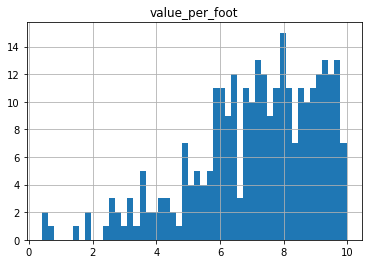

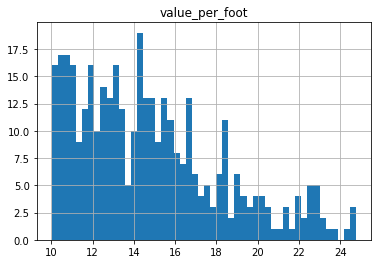

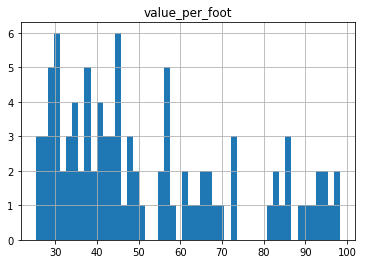

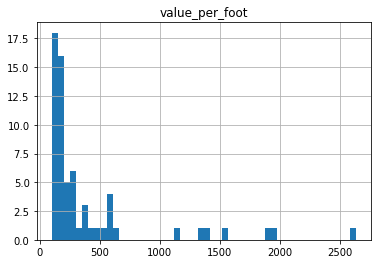

In [35]:
catSmall = 10
catMedium = 25
catBig = 100

df_pluto_subset_small = df_pluto_subset.query('value_per_foot < {}'.format(catSmall))
df_pluto_subset_med = df_pluto_subset.query('value_per_foot >= {} & value_per_foot < {}'.format(catSmall, catMedium))
df_pluto_subset_big = df_pluto_subset.query('value_per_foot >= {} & value_per_foot < {}'.format(catMedium, catBig))
df_pluto_subset_xl = df_pluto_subset.query('value_per_foot >= {}'.format(catBig))

df_pluto_subset_small.hist(column='value_per_foot', bins=50)
df_pluto_subset_med.hist(column='value_per_foot', bins=50)
df_pluto_subset_big.hist(column='value_per_foot', bins=50)
df_pluto_subset_xl.hist(column='value_per_foot', bins=50)

**Add the categorical values to the original data frame**

In [19]:
df_pluto['price_small'] = 0
df_pluto['price_medium'] = 0
df_pluto['price_big'] = 0
df_pluto['price_xl'] = 0

df_pluto.loc[df_pluto.value_per_foot<catSmall, 'price_small'] = 1
df_pluto.loc[(df_pluto.value_per_foot>=catSmall) & (df_pluto.value_per_foot<catMedium), 'price_medium'] = 1
df_pluto.loc[(df_pluto.value_per_foot>=catMedium) & (df_pluto.value_per_foot<catBig), 'price_big'] = 1
df_pluto.loc[df_pluto.value_per_foot>=catBig, 'price_xl'] = 1

df_pluto.head()

,lotarea,assesstot,xcoord,ycoord,value_per_foot,Longitude,Latitude,price_small,price_medium,price_big,price_xl
1,32218,72573951,980160.0,200125.0,2252.590198,-74.014675,40.709521,0,0,0,1
2,11255,2641050,980389.0,197506.0,234.655709,-74.013852,40.702512,0,0,0,1
3,4613,684900,980357.0,197392.0,148.471710,-74.013967,40.702207,0,0,0,1
4,1410,820800,982388.0,198261.0,582.127660,-74.006667,40.704533,0,0,0,1
5,1455,531450,983352.0,196911.0,365.257732,-74.003202,40.700920,0,0,0,1


### 3. Police stations

Police precincts are the first proof of concept (PoC) category of points of interest (PoI) to evaluate whether user preferences for some category can give better recommendations of new business locations on a tax lot level.

#### 3.1 Scrape the NYPD web page
We extract and cleanse strings indicating the precincts and their addresses so we can later find the coordinates.

In [20]:
url = 'https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
table = soup.find('div', class_='about-description').find('table')

precincts = []
addresses = []
for row in table.select('tr'):
    children = row.findChildren(recursive=False)
    
    # only extract the valid rows
    if len(children) > 2 and children[0].name == 'td':
        precincts.append(children[0].get_text().strip())
        addresses.append(children[2].get_text().strip())

df_nypd = pd.DataFrame({ 'precinct': precincts, 'address': addresses })
df_nypd.head()

,address,precinct
0,16 Ericsson Place,1st Precinct
1,19 Elizabeth Street,5th Precinct
2,233 West 10 Street,6th Precinct
3,19 1/2 Pitt Street,7th Precinct
4,321 East 5 Street,9th Precinct


#### 3.2 Retrieve coordinates for precincts
We need to fetch the coordinates for the addresses in order to calculate a vector according to the new business preferences.

In [21]:
geolocator = Nominatim(user_agent='my-data-science-project')

df_nypd = df_nypd.assign(Longitude=np.nan, Latitude=np.nan)
for i, row in df_nypd.iterrows():
    try:
        addr = '{}, New York City'.format(row['address'])
        location = geolocator.geocode(addr, timeout=10)
        if location != None:
            df_nypd.loc[i, 'Longitude'] = location.longitude
            df_nypd.loc[i, 'Latitude'] = location.latitude
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(addr, e.message))

print(df_nypd.shape)
df_nypd.head()

(77, 4)


,address,precinct,Latitude,Longitude
0,16 Ericsson Place,1st Precinct,NaN,NaN
1,19 Elizabeth Street,5th Precinct,40.716182,-73.997463
2,233 West 10 Street,6th Precinct,NaN,NaN
3,19 1/2 Pitt Street,7th Precinct,40.716287,-73.983770
4,321 East 5 Street,9th Precinct,NaN,NaN


Some coordinates are missing... either add them manually or drop them!

#### 3.3 Manually add missing coordinates
This information has a potentially big impact on the recommendation. The manual effort only requires the correction of four records. Therefore we invest this one-time effort to improve the future model.

In [22]:
dt = pd.DataFrame({
    'address': ['16 Ericsson Place', '168-02 P.O Edward Byrne Ave.', '233 West 10 Street', '321 East 5 Street', '2271-89 8th Avenue'],
    'Latitude': [40.7202702, 40.7070813, 40.7342372, 40.7265631, 40.8088575],
    'Longitude': [-74.0093916, -73.7948334, -74.0076419, -73.9900125, -73.9548177]
})
for i, row in dt.iterrows():
    idx = df_nypd.index[df_nypd['address'] == row.address]
    df_nypd.loc[idx, 'Longitude'] = row.Longitude
    df_nypd.loc[idx, 'Latitude'] = row.Latitude

In [23]:
df_nypd.shape

(77, 4)

Check and drop any null columns left

In [24]:
df_nypd[df_nypd.isnull().any(axis=1)].head()

,address,precinct,Latitude,Longitude


In [25]:
df_nypd.dropna(subset=['Latitude', 'Longitude'])
df_nypd.shape

(77, 4)

#### 3.4 Display the remaining police precincts alongside the neighborhood centers

In [26]:
def addMarker(row):
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        color='blue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.7,
        popup=row.precinct + ': ' + row.address
    ).add_to(map_newyork)
    
df_nypd.dropna(inplace=True)
df_nypd.apply(addMarker, axis=1)
map_newyork

In the map above we can see the centroids of the neighborhoods which will be recommended by the system (orange circles). We also see the police stations (blue circles). If the user of the future model decides to define an attraction towards police stations, the closest station to the recommended neighborhood will generate a vectorized pull towards the police station, away from the neighborhood center.

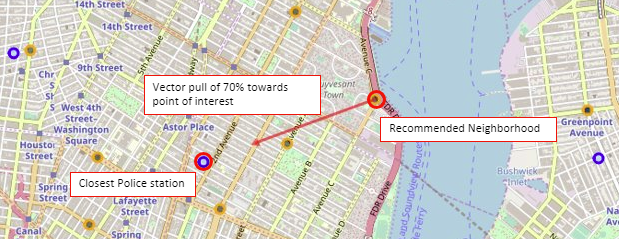

#### 3.5 Compute & Visualize the pull towards the next police station
Filter for an example neighborhood and the closest example police station:

In [27]:
example_neighborhood = neighborhoods[neighborhoods['Neighborhood'].str.match('Stuyvesant Town')]
example_station = df_nypd[df_nypd['precinct'].str.match('9th Precinct')]

In [28]:
example_neighborhood

,Borough,Neighborhood,Latitude,Longitude
275,Manhattan,Stuyvesant Town,40.731,-73.974052


In [29]:
example_station

,address,precinct,Latitude,Longitude
4,321 East 5 Street,9th Precinct,40.726563,-73.990013


Define functions for bearing calculation and to draw an arrow on a map

In [30]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2. Found on https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

In [31]:
def draw_arrow(v1, v2, map_draw, size=6):
    norm = np.linalg.norm(v1-v2)
    # go back a bit before drawing, so the polygon marker doesn't overlap
    v2new = v2 - (v2-v1)*norm
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    pp1 = Point(v1[0], v1[1])
    pp2 = Point(v2new[0], v2new[1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(pp1, pp2) - 90
    folium.PolyLine(locations=[v1.tolist(), v2new.tolist()],
                             opacity=0.7,
                             color='red').add_to(map_draw)
    folium.RegularPolygonMarker(location=pp2, 
        color=None,
        fill_opacity=0.7,
        fill_color='red',
        number_of_sides=3, 
        radius=size,
        rotation=rotation).add_to(map_draw)

Fetch the latitute and longitude of the neighborhhod and the police station. Then simulate that the user finds it 70% important that his new business will be located close to a police station. This is achieved by calculating the new recommended location and visualizing the arrow pulling towards it, closer to the police station.

In [32]:
p1 = example_neighborhood[['Latitude', 'Longitude']].values[0]
p2 = example_station[['Latitude', 'Longitude']].values[0]
importance = 0.7
recommended = p1 + (p2-p1)*importance

In [33]:
draw_arrow(p1, recommended, map_newyork)
map_newyork

Showing this, we have proven that, after a neighborhood has been recommended, it is possible to apply additional preferences for certain categories, which will improve the recommendation system drastically. This gives the engine an extensible nature which leads to even better reccomendations, the more point of interest categories are included.

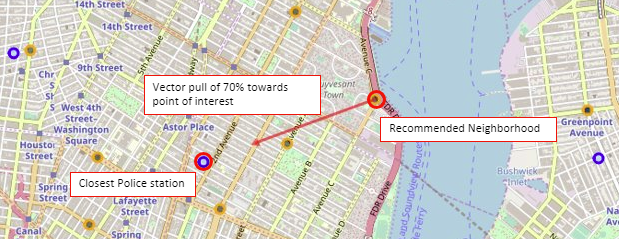

## Methodology

## Results

## Discussion

## Conclusion